In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
# Path to dataset (NOTE: You must adjust this path to your local environment)
data_dir = r"E:\Spectra\brain_tumor_dataset"

yes_path = os.path.join(data_dir, "yes")
no_path = os.path.join(data_dir, "no")

IMG_SIZE = 150
images, labels = [], []

# Load and preprocess
for folder, label in [(yes_path, 1), (no_path, 0)]:
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            labels.append(label)
        except:
            continue

images = np.array(images, dtype="float32") / 255.0
labels = np.array(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))

Train samples: 202
Test samples: 51


In [4]:
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# 1. Define the Input layer and store the input tensor
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# 2. Define the convolutional base
x = Conv2D(32, (3,3), activation='relu')(inputs)
x = MaxPooling2D(2,2)(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)

# Store the output of the last Conv2D block's output
x = Conv2D(128, (3,3), activation='relu')(x)
last_conv_output = x # ✅ TENSOR STORED FOR GRAD-CAM

x = MaxPooling2D(2,2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# 3. Define the output layer
outputs = Dense(1, activation='sigmoid')(x)
# Store the tensor *before* the final sigmoid activation (the logits)
logit_tensor = x # ✅ TENSOR STORED FOR SHAP

# 4. Create the final model
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_test, y_test),
    batch_size=32,
    verbose=1
)

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 602ms/step - accuracy: 0.6335 - loss: 0.7672 - val_accuracy: 0.6275 - val_loss: 0.5946
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 450ms/step - accuracy: 0.6847 - loss: 0.5778 - val_accuracy: 0.7843 - val_loss: 0.4996
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 441ms/step - accuracy: 0.7743 - loss: 0.4905 - val_accuracy: 0.6863 - val_loss: 0.6609
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 446ms/step - accuracy: 0.7144 - loss: 0.6196 - val_accuracy: 0.7647 - val_loss: 0.4829
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 451ms/step - accuracy: 0.8058 - loss: 0.5133 - val_accuracy: 0.8039 - val_loss: 0.4162


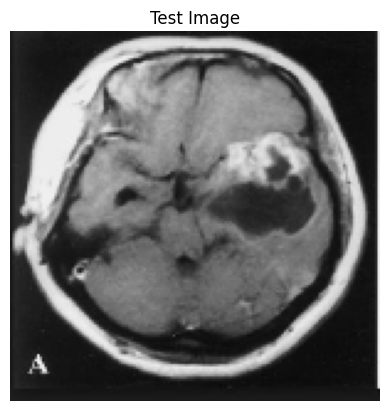

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
Prediction Score: 0.8642 → Tumor
Actual Label: Tumor


In [7]:
idx = np.random.randint(0, len(X_test))
sample_img = X_test[idx]
true_label = y_test[idx]

plt.imshow(sample_img)
plt.axis('off')
plt.title("Test Image")
plt.show()

pred = model.predict(np.expand_dims(sample_img, axis=0))[0][0]
print(f"Prediction Score: {pred:.4f} →", "Tumor" if pred > 0.5 else "No Tumor")
print(f"Actual Label: {'Tumor' if true_label == 1 else 'No Tumor'}")

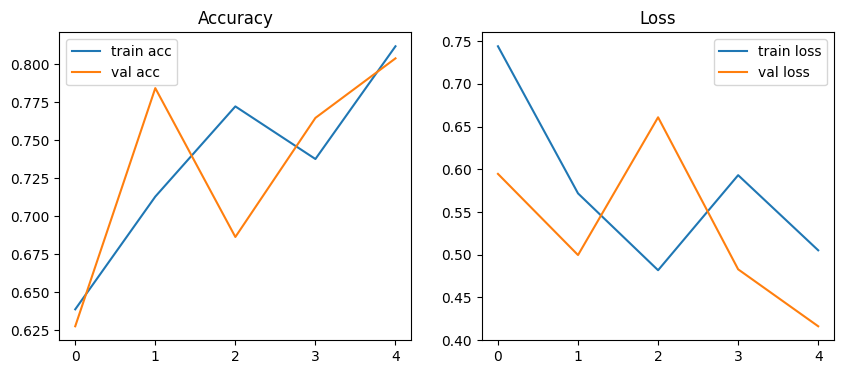

In [6]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Loss")
plt.legend()
plt.show()

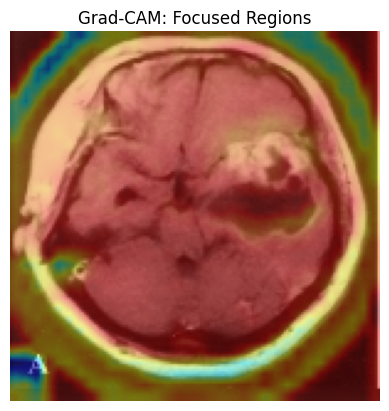

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model

# ✅ Create Grad-CAM model using the explicit tensors stored in Cell 3
grad_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=[last_conv_output, model.output] 
)

# ✅ Prepare the image
img_tensor = tf.cast(np.expand_dims(sample_img, axis=0), tf.float32)

# ✅ Compute Grad-CAM
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_tensor)
    
    # Use the model's prediction score for loss
    if predictions[0] > 0.5:
        loss = predictions[:, 0]
    else:
        loss = 1.0 - predictions[:, 0]
    
# Gradient of the output w.r.t. feature maps
grads = tape.gradient(loss, conv_outputs)

# Average the gradients over all feature map positions
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Weight the convolution outputs
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

# Normalize and resize
heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)
# ✅ CORRECTION: Remove .numpy()
heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE)) 

# ✅ Overlay heatmap on original image
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(np.uint8(sample_img * 255), 0.6, heatmap_color, 0.4, 0)

plt.imshow(overlay)
plt.title("Grad-CAM: Focused Regions")
plt.axis('off')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

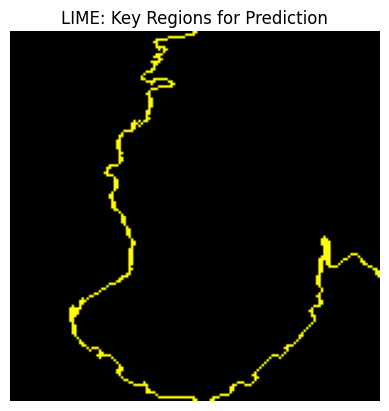

In [9]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

lime_img = X_test[2]
explanation = explainer.explain_instance(
    image=lime_img,
    classifier_fn=lambda x: model.predict(x),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

lime_img, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(lime_img / 255.0, mask))
plt.title("LIME: Key Regions for Prediction")
plt.axis('off')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

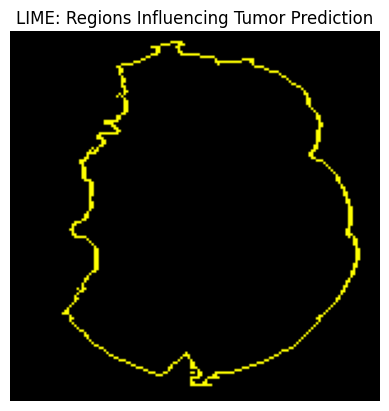

In [10]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Choose a test image
lime_img = X_test[3]

# Explain model prediction using LIME
explanation = explainer.explain_instance(
    image=lime_img,
    classifier_fn=lambda x: model.predict(x),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Get visualization mask
lime_img, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(lime_img / 255.0, mask))
plt.title("LIME: Regions Influencing Tumor Prediction")
plt.axis('off')
plt.show()